# rGreat vs greatpy

This notebook enable you to compare results between local rGreat online, rGREAT local and greatpy. 

r-base  ==  3.6.1

python version  ==  3.8 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import rpy2
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects import r as r
pandas2ri.activate()
import pandas as pd

import os 
import matplotlib.pyplot as plt
import greatpy as great 
from scipy.stats import pearsonr
import re
import time 
import seaborn as sns 
import numpy as np
import warnings

warnings.filterwarnings('ignore')

In [4]:
importr('rGREAT')
ranges = importr('GenomicRanges')

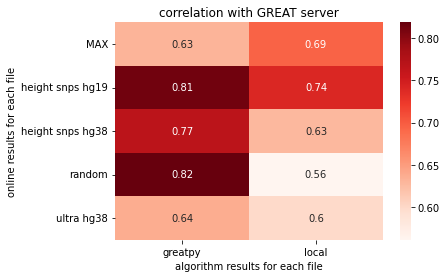

In [12]:
great.tl.online_vs_local_vs_greatpy_comparison()

## With threshold = 0.05 on fdr correction 

In [7]:
from statsmodels.stats.multitest import multipletests

In [8]:
stat = {
        "name" : [], 
        "binom_correlation" : [],
    }

for name in ["01_random.bed","06_height_snps_hg38.bed","07_height_snps_hg19.bed","10_MAX.bed"] : 
    file_out = name.split(".")

     # find the assembly 
    if re.match(".*hg19.*",name) !=  None : 
        assembly = "hg19"
    else : 
        assembly = "hg38"

    # online test 
    res_online = rpy2.robjects.r['submitGreatJob'](f"../data/tests/test_data/input/{name}",species = f"{assembly}",help = False)
    res_online = rpy2.robjects.r['getEnrichmentTables'](res_online)
    # create each dataframe
            # online
    name_online = [cdc.lower() for cdc in list(res_online.rx2("GO Molecular Function").rx2("name"))+list(res_online.rx2("GO Biological Process").rx2("name"))+list(res_online.rx2("GO Cellular Component").rx2("name"))]
    online = pd.DataFrame({
        "id" : list(res_online.rx2("GO Molecular Function").rx2("ID"))+list(res_online.rx2("GO Biological Process").rx2("ID"))+list(res_online.rx2("GO Cellular Component").rx2("ID")),
        "name" : name_online,
        "binom_p_val" : list(res_online.rx2("GO Molecular Function").rx2("Binom_Raw_PValue"))+list(res_online.rx2("GO Biological Process").rx2("Binom_Raw_PValue"))+list(res_online.rx2("GO Cellular Component").rx2("Binom_Raw_PValue")),
        "hyper_p_val" : list(res_online.rx2("GO Molecular Function").rx2("Hyper_Raw_PValue"))+list(res_online.rx2("GO Biological Process").rx2("Hyper_Raw_PValue"))+list(res_online.rx2("GO Cellular Component").rx2("Hyper_Raw_PValue"))
        })

    greatpy = great.tl.Great.enrichment(
            test_file = f"../data/tests/test_data/input/{name}",
            regdom_file = f"../data/human/{assembly}/regulatory_domain.bed",
            chr_size_file = f"../data/human/{assembly}/chr_size.bed",
            annotation_file = f"../data/human/ontologies.csv",
            binom = True,
            hypergeom = True,
            )

        

    online["binom_fdr"] = multipletests(online["binom_p_val"], alpha = 0.05, method = 'fdr_bh')[1]

    # réduction of df 
    greatpy = greatpy[greatpy["binom_fdr"] <=  0.1]
    online = online[online["binom_fdr"] <=  0.1]

    print(f"after threshold : greatpy shape = {greatpy.shape[0]}, online shape = {online.shape[0]}")
    greatpy = greatpy[greatpy.index.isin(list(online["id"]))]
    online = online[online["id"].isin(list(greatpy.index))]

    print(f"after get same go ID : greatpy shape = {greatpy.shape[0]}, online shape = {online.shape[0]} \n")

    
    stat["name"].append(file_out[0])
    try : 
        stat["binom_correlation"].append(pearsonr(online["binom_fdr"],greatpy["binom_fdr"])[0])
    except : 
        stat["binom_correlation"].append(f"Error : df.shape = {online.shape[0]}")

pd.DataFrame(stat)


after threshold : greatpy shape = 292, online shape = 144
after get same go ID : greatpy shape = 82, online shape = 82 

after threshold : greatpy shape = 494, online shape = 577
after get same go ID : greatpy shape = 217, online shape = 217 

after threshold : greatpy shape = 553, online shape = 652
after get same go ID : greatpy shape = 242, online shape = 242 

after threshold : greatpy shape = 3, online shape = 17
after get same go ID : greatpy shape = 1, online shape = 1 



,name,binom_correlation
0,01_random,3.74254e-01
1,06_height_snps_hg38,4.73357e-01
2,07_height_snps_hg19,3.94162e-01
3,10_MAX,Error : df.shape = 1
